In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [2]:
import json 
json_dir = '/root/notebooks/0858611-2/tooth_xray/model/all_tooth_data_set/mapping.json'
with open(json_dir) as json_file:
    json_data = json.load(json_file)
    

In [3]:
def get_level(mean):
    if mean>=0 and mean<=2:
        return 'normal'
    elif mean>=3 and mean<=4:
        return 'medium'
    elif mean>4:
        return 'serious'
    else:
        return 'over_range'

In [4]:
from statistics import mean
import pandas as pd
img_path = []
img_cal = []
img_cal_mean = []
img_cal_level = []

for key in json_data:
    try:
        new_path = key.replace("Dataset/Images", "/root/notebooks/0858611-2/tooth_xray/model/all_tooth_data_set/Images")
        mean_cal = int(mean(json_data[key]))
        img_cal_level.append(get_level(mean_cal))
        img_cal_mean.append(str(mean_cal))
        img_path.append(new_path)
        img_cal.append(json_data[key])
    except:
        print(key,json_data[key])
        pass
    

Dataset/Images/037621_12_.png None
Dataset/Images/037621_13_.png None
Dataset/Images/037621_26_.png None
Dataset/Images/037621_25_.png None
Dataset/Images/039462_14_.png None
Dataset/Images/039462_22_.png None
Dataset/Images/039462_21_.png None


In [5]:
print(len(img_path))
print(len(img_cal))
print(len(img_cal_mean))
print(len(img_cal_level))
print(img_cal_level.count('normal'))
print(img_cal_level.count('medium'))
print(img_cal_level.count('serious'))

1506
1506
1506
1506
699
346
109


In [6]:
import pandas as pd

dict = {"image_path": img_path,  
        "img_cal": img_cal,
        "img_cal_mean":img_cal_mean,
        "img_cal_level":img_cal_level
       }

tooth_dataframe = pd.DataFrame(dict)
print(tooth_dataframe.head())

                                          image_path img_cal img_cal_mean  \
0  /root/notebooks/0858611-2/tooth_xray/model/all...  [5, 3]            4   
1  /root/notebooks/0858611-2/tooth_xray/model/all...  [3, 4]            3   
2  /root/notebooks/0858611-2/tooth_xray/model/all...  [7, 9]            8   
3  /root/notebooks/0858611-2/tooth_xray/model/all...  [4, 5]            4   
4  /root/notebooks/0858611-2/tooth_xray/model/all...  [4, 3]            3   

  img_cal_level  
0        medium  
1        medium  
2       serious  
3        medium  
4        medium  


In [7]:
tooth_dataframe = tooth_dataframe[tooth_dataframe.img_cal_level != 'over_range']

normal_dataframe = tooth_dataframe[tooth_dataframe.img_cal_level == 'normal']
medium_dataframe = tooth_dataframe[tooth_dataframe.img_cal_level == 'medium']
serious_dataframe = tooth_dataframe[tooth_dataframe.img_cal_level == 'serious']
print(tooth_dataframe[:5])

                                          image_path img_cal img_cal_mean  \
0  /root/notebooks/0858611-2/tooth_xray/model/all...  [5, 3]            4   
1  /root/notebooks/0858611-2/tooth_xray/model/all...  [3, 4]            3   
2  /root/notebooks/0858611-2/tooth_xray/model/all...  [7, 9]            8   
3  /root/notebooks/0858611-2/tooth_xray/model/all...  [4, 5]            4   
4  /root/notebooks/0858611-2/tooth_xray/model/all...  [4, 3]            3   

  img_cal_level  
0        medium  
1        medium  
2       serious  
3        medium  
4        medium  


In [8]:
#img to array and resize 
import cv2
import numpy as np

def imgpath_list_to_array_list(imgpath_list,imgsize=(256,256)):
    array_list = []
    for img_path in imgpath_list:
        img = cv2.imread(img_path)
        img = cv2.resize(img,imgsize)
        #img = (img-127.5)/127.5
        array_list.append(img)
    return np.array(array_list)

def label_list_to_num(train_label):
    label_array = []
    for symptom in train_label:
        if symptom == 'normal':
            label_array.append(0)
        if symptom == 'medium':
            label_array.append(1)
        if symptom == 'serious':
            label_array.append(2)
    return np.array(label_array)

train_data_array = imgpath_list_to_array_list(tooth_dataframe.image_path)
train_label_array = label_list_to_num(tooth_dataframe.img_cal_level)

normal_data_array = imgpath_list_to_array_list(normal_dataframe.image_path)
normal_label_array = label_list_to_num(normal_dataframe.img_cal_level)
medium_data_array = imgpath_list_to_array_list(medium_dataframe.image_path)
medium_label_array= label_list_to_num(medium_dataframe.img_cal_level)
serious_data_array = imgpath_list_to_array_list(serious_dataframe.image_path)
serious_label_array = label_list_to_num(serious_dataframe.img_cal_level)


print(train_data_array.shape)
print(train_label_array.shape)

(1154, 256, 256, 3)
(1154,)


In [9]:
# for i in range(100):
#     maxtest = normal_data_array[i].reshape(256*256*3,1)
#     print(max(maxtest))
#     print(min(maxtest))

In [10]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256,256, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(2048, activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(3))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0

In [11]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
history = model1.fit(train_data_array[:1000], train_label_array[:1000], epochs=30, 
                    validation_data=(train_data_array[1000:], train_label_array[1000:]),shuffle=True)

Train on 1000 samples, validate on 154 samples
Epoch 1/30
1000/1000 [==============================] - 6s 6ms/sample - loss: 66.2643 - accuracy: 0.4850 - val_loss: 1.0001 - val_accuracy: 0.6883
Epoch 2/30
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.9254 - accuracy: 0.5930 - val_loss: 0.9834 - val_accuracy: 0.6753
Epoch 3/30
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.8673 - accuracy: 0.6000 - val_loss: 0.9727 - val_accuracy: 0.6818
Epoch 4/30
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.8124 - accuracy: 0.6250 - val_loss: 0.9609 - val_accuracy: 0.6818
Epoch 5/30
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.6887 - accuracy: 0.6900 - val_loss: 0.9964 - val_accuracy: 0.6948
Epoch 6/30
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.5736 - accuracy: 0.7650 - val_loss: 1.0426 - val_accuracy: 0.6429
Epoch 7/30
1000/1000 [==============================] - 1s 1ms/sample - loss

154/1 - 0s - loss: 3.1751 - accuracy: 0.5390


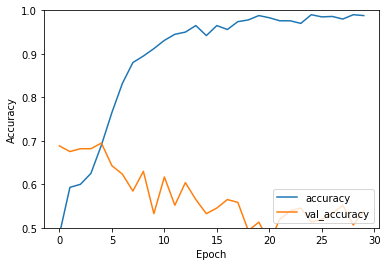

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model1.evaluate(train_data_array[1000:],  train_label_array[1000:], verbose=2)

In [14]:
model1.evaluate(train_data_array[1000:],  train_label_array[1000:], verbose=2)

154/1 - 0s - loss: 3.1751 - accuracy: 0.5390


[3.3506722233512183, 0.53896105]

In [15]:
print('following is recall rate')
print('\n# Evaluate on normal_data')
model1.evaluate(normal_data_array,normal_label_array, verbose=2)

print('\n# Evaluate on medium_data')
model1.evaluate(medium_data_array,medium_label_array, verbose=2)

print('\n# Evaluate on serious_data')
model1.evaluate(serious_data_array,serious_label_array, verbose=2)

following is recall rate

# Evaluate on normal_data
699/1 - 0s - loss: 1.6293 - accuracy: 0.9514

# Evaluate on medium_data
346/1 - 0s - loss: 0.7144 - accuracy: 0.9538

# Evaluate on serious_data
109/1 - 0s - loss: 4.6267 - accuracy: 0.7431


[2.436886237618095, 0.74311924]

In [16]:
#recall rate

In [17]:
model_predict =[]
for img in train_data_array:
    reshape = img.reshape(1,256,256,3)
    image = tf.cast(reshape, tf.float32)
    model_predict.append(np.argmax(model1.predict(image)))

In [18]:
# def recall_rate(model_predict_array,test_label_array):
#     target_set = set(train_label_array)
#     correct = []
#     for index,actually_label in enumerate(test_label_array):
#         if model_predict_array[index] == actually_label:
#             correct.append(actually_label)
            
#     for target in target_set:
#         print('The target {} recall rate is {} %'.format(target,correct.count(target)/list(test_label_array).count(target))) 
#         print('The target {} training accuracy is {} %'.format(target,correct.count(target)/list(model_predict_array).count(target)))

In [19]:
#recall_rate(model_predict,train_label_array)

In [29]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(train_label_array, model_predict)
print(matrix)
matrix_split = np.split(matrix,3,axis=1)
print(matrix_split)

[[665  32   2]
 [ 15 330   1]
 [ 18  10  81]]
[array([[665],
       [ 15],
       [ 18]]), array([[ 32],
       [330],
       [ 10]]), array([[ 2],
       [ 1],
       [81]])]


In [33]:
print(matrix_split[0].shape)

(3, 1)


In [36]:
import pandas as pd

dict = {#"": img_path,
        "class:0":matrix_split[0].reshape(3),
        "class:1":matrix_split[1].reshape(3),
        "class:2":matrix_split[2].reshape(3)
       }

predict_table = pd.DataFrame(dict)
print(predict_table.head())

   class:0  class:1  class:2
0      665       32        2
1       15      330        1
2       18       10       81
